In [2]:
# Train a CNN regression to predict the mCG level of all DMRs
import pandas as pd
import numpy as np
import time, re
import matplotlib.pyplot as plt

# Quantify mCG at the enhancers

In [3]:
# bed_file='enhancers_reptile.bed'
# allc_dir='/cndd2/fangming/scf_enhancers/data/bulk/round2/mc/'
# allc_files=glob.glob(allc_dir+'Round2*CGN-Merge.allc.tsv.gz')

# # bed_file='foo.bed'
# # allc_files = [allc_files[0]]

# output_files = ['enh.'+os.path.split(a)[1][:-22]+'.bed.gz' for a in allc_files]
# cap = 0 # no counts cap
# nprocs = 8
# compress = True
# bed_file_name_column = False
# chr_prefix = True
# contexts = ['CG']

# run_mc_region_level(allc_files, 
#                     output_files, 
#                     bed_file, 
#                     chr_prefix=chr_prefix,
#                     bed_file_name_column=bed_file_name_column,
#                     contexts=contexts,
#                     compress=compress, 
#                     cap=cap,
#                     nprocs=nprocs);

In [4]:
# # Gather data from all the individual bed files
# df = pd.DataFrame();
# for fn in output_files:
    
#     _, sample = os.path.split(fn)
#     sample = re.sub('(enh\.|\.bed)','',sample)

#     x = pd.read_csv(fn+'.gz',sep='\t')
#     x=x.rename(mapper={'mCG': sample+'_'+'mCG', 'CG': sample+'_'+'CG'}, axis=1)
#     if df.shape[0]<1:
#         df = x
#     else:
#         df = df.join(x.iloc[:,[3,4]])
        
# df['enh_pos'] = 'chr'+df['chr'].astype(str)+'_'+df['start'].astype(str)+'_'+df['end'].astype(str)

In [5]:
# df.to_csv('enh.AllClusters.mCG.bed.gz')

In [6]:
# for fn in output_files:
#     os.remove(fn)
#     print('Removed file %s' % fn)

# Load enhancer data

In [7]:
# # Add strand info to the bed file for each gene
# transcripts = pd.read_csv(datadir+'gencode_vM16_transcript_annotation.bed',sep='\t',
#                           header=None,
#                           names=['trans_chr','trans_start','trans_end','strand','ensmust','gene_name_trans','ensid_full','gene_name'])
# transcripts['ensid'] = [re.sub("\..*","",x) for x in transcripts.ensid_full]
# transcripts = transcripts.set_index('ensid',drop=False)
# transcripts
# 
# genes = pd.read_csv(datadir+'genes.gencode.vM16.bed',sep='\t',header=None,
#                    names=['chr','start','end','ensid','gene'])
# genes['ensid'] = [re.sub('\..*','',ensid) for ensid in genes['ensid']]
# genes = genes.set_index('ensid',drop=False)
# genes = genes.iloc[[x!='chrY' for x in genes['chr']],:]

# genes=genes.join(transcripts.loc[:,['ensid','strand']].drop_duplicates().loc[:,'strand'])
# genes = genes.loc[:,['chr','start','end','strand','ensid','gene']]
# genes.to_csv(datadir+'genes.gencode.vM16.strand.bed',sep='\t',index=False,header=False)
# genes

datadir = '/cndd/emukamel/enhancer_modeling/enhancer_data/'
genes = pd.read_csv(datadir+'genes.gencode.vM16.strand.bed',sep='\t',header=None,
                   names=['chr','start','end','strand','ensid','gene'])
genes = genes.set_index('ensid',drop=False)
genes

,chr,start,end,strand,ensid,gene
ensid,,,,,,
ENSMUSG00000102693,chr1,3073253,3074322,+,ENSMUSG00000102693,4933401J01Rik
ENSMUSG00000064842,chr1,3102016,3102125,+,ENSMUSG00000064842,Gm26206
ENSMUSG00000051951,chr1,3205901,3671498,-,ENSMUSG00000051951,Xkr4
ENSMUSG00000102851,chr1,3252757,3253236,+,ENSMUSG00000102851,Gm18956
ENSMUSG00000103377,chr1,3365731,3368549,-,ENSMUSG00000103377,Gm37180
...,...,...,...,...,...,...
ENSMUSG00000086695,chrX,169985801,169986939,-,ENSMUSG00000086695,Gm15247
ENSMUSG00000095562,chrX,170009659,170019281,+,ENSMUSG00000095562,Gm21887
ENSMUSG00000093806,chrX,170672644,170678054,+,ENSMUSG00000093806,Asmt


In [4]:
# Map the genes to closest enhancers
datadir = '/cndd/emukamel/enhancer_modeling/enhancer_data/'
genes2enh = pd.read_csv(datadir+'genes.gencode.vM16.enhancers_within_100kb.bed',sep='\t',
                        names = ['gene_chr','gene_start','gene_end','gene_strand','ensid','gene_name','enh_chr','enh_start','enh_end'])

slopsize=1e5
genes2enh['enh_end'] = genes2enh['enh_end']-slops
genes2enh['enh_start'] = genes2enh['enh_start']+20000

get_tss = lambda x : x['gene_start'] if (x['gene_strand']=='+') else x['gene_end']
genes2enh['tss'] = genes2enh.apply(get_tss, axis=1)

genes2enh['enh_ctr'] = (genes2enh['enh_start']+genes2enh['enh_end'])/2

In [5]:
# Get signed distance to the TSS
genes2enh['dtss'] = (genes2enh['enh_ctr']-genes2enh['tss']) * ((genes2enh['gene_strand']=='+')*2-1)
genes2enh = genes2enh.loc[genes2enh['enh_start']!=-1,:]
genes2enh

,gene_chr,gene_start,gene_end,gene_strand,ensid,gene_name,enh_chr,enh_start,enh_end,tss,enh_ctr,dtss
0,chr1,3073253,3074322,+,ENSMUSG00000102693,4933401J01Rik,chr1,3083769,3083816,3073253,3083792.5,10539.5
1,chr1,3102016,3102125,+,ENSMUSG00000064842,Gm26206,chr1,3083769,3083816,3102016,3083792.5,-18223.5
2,chr1,3102016,3102125,+,ENSMUSG00000064842,Gm26206,chr1,3112234,3112467,3102016,3112350.5,10334.5
3,chr1,3102016,3102125,+,ENSMUSG00000064842,Gm26206,chr1,3112770,3112986,3102016,3112878.0,10862.0
4,chr1,3102016,3102125,+,ENSMUSG00000064842,Gm26206,chr1,3113717,3114035,3102016,3113876.0,11860.0
...,...,...,...,...,...,...,...,...,...,...,...,...
475636,chrX,169985801,169986939,-,ENSMUSG00000086695,Gm15247,chrX,169983814,169984232,169986939,169984023.0,2916.0
475637,chrX,170009659,170019281,+,ENSMUSG00000095562,Gm21887,.,19999,-20001,170009659,-1.0,-170009660.0
475638,chrX,170672644,170678054,+,ENSMUSG00000093806,Asmt,.,19999,-20001,170672644,-1.0,-170672645.0
475639,chrX,170746836,170747207,-,ENSMUSG00000096661,Gm15069,.,19999,-20001,170747207,-1.0,170747208.0


In [6]:
genes2enh['enh_pos'] = genes2enh['enh_chr']+'_'+genes2enh['enh_start'].astype(str)+'_'+genes2enh['enh_end'].astype(str)

In [7]:
genes2enh.ensid = [re.sub("\..*","",x) for x in genes2enh.ensid]
genes2enh = genes2enh.set_index('ensid', drop=False)
genes2enh

,gene_chr,gene_start,gene_end,gene_strand,ensid,gene_name,enh_chr,enh_start,enh_end,tss,enh_ctr,dtss,enh_pos
ensid,,,,,,,,,,,,,
ENSMUSG00000102693,chr1,3073253,3074322,+,ENSMUSG00000102693,4933401J01Rik,chr1,3083769,3083816,3073253,3083792.5,10539.5,chr1_3083769_3083816
ENSMUSG00000064842,chr1,3102016,3102125,+,ENSMUSG00000064842,Gm26206,chr1,3083769,3083816,3102016,3083792.5,-18223.5,chr1_3083769_3083816
ENSMUSG00000064842,chr1,3102016,3102125,+,ENSMUSG00000064842,Gm26206,chr1,3112234,3112467,3102016,3112350.5,10334.5,chr1_3112234_3112467
ENSMUSG00000064842,chr1,3102016,3102125,+,ENSMUSG00000064842,Gm26206,chr1,3112770,3112986,3102016,3112878.0,10862.0,chr1_3112770_3112986
ENSMUSG00000064842,chr1,3102016,3102125,+,ENSMUSG00000064842,Gm26206,chr1,3113717,3114035,3102016,3113876.0,11860.0,chr1_3113717_3114035
...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSMUSG00000086695,chrX,169985801,169986939,-,ENSMUSG00000086695,Gm15247,chrX,169983814,169984232,169986939,169984023.0,2916.0,chrX_169983814_169984232
ENSMUSG00000095562,chrX,170009659,170019281,+,ENSMUSG00000095562,Gm21887,.,19999,-20001,170009659,-1.0,-170009660.0,._19999_-20001
ENSMUSG00000093806,chrX,170672644,170678054,+,ENSMUSG00000093806,Asmt,.,19999,-20001,170672644,-1.0,-170672645.0,._19999_-20001


# Load RNA data

In [183]:
# datadir='/cndd2/ethan/projects/scf_paper/modeling/working_data/reptile/data_for_model_01152020/' # 10x vs scRNA
# rna = pd.read_csv(datadir+'rna_for_y_values.tsv',sep='\t')
# rcol = rna.columns.values
# rcol[1] = 'ensid'
# rna.columns = rcol
# # rna=rna.drop('10-1',axis=1)
# # rna_data = rna.iloc[:,2:].to_numpy()

# # Variable genes
# hvg = np.var(rna.iloc[:,2:].to_numpy(),axis=1);
# hvg = hvg> np.percentile(hvg,50)
# np.sum(hvg)

# rna = rna[hvg]

In [184]:
# rna = rna.set_index('ensid')

In [9]:
# Load different RNA datasets
rnadir = '/cndd/emukamel/BICCN-Mouse-MOp/supp_tables/Table_S5_GeneByCluster/'
# scf_l2 = ['1-1-1', '1-2-1', '1-2-2', '10-1-1', '2-1-1', '2-1-2',
#        '2-2-1', '2-2-2', '2-2-3', '2-2-4', '2-3-1', '2-3-2', '2-3-3', '3-1-1',
#        '3-1-2', '3-2-1', '3-2-2', '3-3-1', '4-1-1', '4-1-2', '4-2-1', '4-2-2',
#        '4-2-3', '5-1-1', '5-1-2', '5-2-1', '5-2-2', '5-2-3', '5-3-1', '5-3-2',
#        '5-4-1', '5-5-1', '6-1-1', '6-1-2', '6-2-1', '6-3-1', '6-3-2', '6-3-3',
#        '6-4-1', '6-4-2', '6-5-1', '6-5-2', '6-5-3', '6-6-1', '7-1-1', '7-1-2',
#        '7-2-1', '7-2-2', '8-1-1', '8-1-2', '8-2-1', '8-3-1', '8-3-2', '9-1-1',
#        '9-2-1', '9-2-2']
scf_l1,scf_l1i = np.unique(np.array([re.sub('-[0-9]$','', i) for i in scf_l2]),return_inverse=True)
scf_l1,scf_l1i

fn = rnadir+'Table_S5b_gene_counts_scRNA_10X_v3_A.tsv.gz'
data_l2 = pd.read_csv(fn,sep='\t',index_col=0)
data_l1 = data_l2.loc[:,[]]
for i in range(len(scf_l1)):
    data_l1.loc[:,scf_l1[i]] = data_l2.iloc[:,scf_l1i==i].sum(axis=1)

data_l1.shape

(31053, 29)

In [10]:
rna = data_l1

# Variable genes
hvg = np.var(rna.iloc[:,2:].to_numpy(),axis=1);
hvg = hvg>np.percentile(hvg,80)
np.sum(hvg)

rna = rna[hvg]

In [11]:
# Subset to the HVGs
print(rna.shape, genes2enh.shape)
ensidu = np.intersect1d(rna.index, genes2enh.index)
genes2enh = genes2enh.loc[ensidu]
rna = rna.loc[ensidu]
print(rna.shape, genes2enh.shape)

(6211, 29) (475641, 13)
(6198, 29) (173733, 13)


# Load mCG data

In [12]:
datadir = '/cndd/emukamel/enhancer_modeling/enhancer_data/'
df = pd.read_csv(datadir+'enh.AllClusters.mCG.bed.gz')
df['enh_pos'] = 'chr'+df['chr'].astype(str)+'_'+df['start'].astype(str)+'_'+df['end'].astype(str)
df = df.drop(['Unnamed: 0'],axis=1)
df

/cndd/emukamel/conda_envs/scanpy/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,chr,start,end,Round2.3-3_mCG,Round2.3-3_CG,Round2.8-2_mCG,Round2.8-2_CG,Round2.2-1_mCG,Round2.2-1_CG,Round2.6-1_mCG,...,Round2.5-5_CG,Round2.2-2_mCG,Round2.2-2_CG,Round2.6-4_mCG,Round2.6-4_CG,Round2.4-1_mCG,Round2.4-1_CG,Round2.6-2_mCG,Round2.6-2_CG,enh_pos
0,1,3083769,3083816,1,1,5,5,31,32,13,...,0,18,20,2,3,15,16,13,14,chr1_3083769_3083816
1,1,3112234,3112467,15,16,27,28,304,315,57,...,0,174,177,15,67,149,164,37,118,chr1_3112234_3112467
2,1,3112770,3112986,0,0,1,4,49,53,7,...,0,30,33,1,10,24,33,6,18,chr1_3112770_3112986
3,1,3113717,3114035,8,14,9,16,35,206,44,...,3,16,125,15,59,55,115,10,95,chr1_3113717_3114035
4,1,3118790,3118935,12,14,2,2,93,130,21,...,0,46,56,14,29,42,89,5,48,chr1_3118790_3118935
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
302091,X,169890644,169890829,2,2,10,10,62,70,0,...,0,39,40,2,16,30,37,1,43,chrX_169890644_169890829
302092,X,169918008,169918093,2,2,3,3,26,26,0,...,0,14,15,0,5,6,6,5,7,chrX_169918008_169918093
302093,X,169927115,169927682,6,35,75,79,243,709,44,...,5,306,412,89,94,204,417,318,340,chrX_169927115_169927682
302094,X,169935048,169935204,3,3,8,9,45,48,17,...,0,31,32,7,7,27,30,25,28,chrX_169935048_169935204


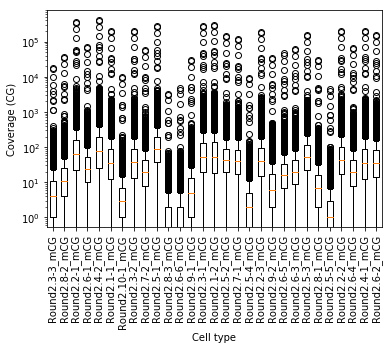

In [28]:
cg = df.iloc[:,3:-1:2]
mcg = df.iloc[:,4:-1:2]

# plt.hist(np.log10(1+mcg.iloc[:,0]), bins=100);
plt.boxplot(cg.iloc[:,:].T, labels=cg.columns);
plt.yscale('log')
plt.ylabel('Coverage (CG)')
plt.xlabel('Cell type')
plt.xticks(rotation=90);

In [33]:
# Compute mCH level
cg = df.iloc[:,3:-1:2]
mcg = df.iloc[:,4:-1:2]
mlevel = mcg.to_numpy() / cg.to_numpy()
hthresh = 15
mlevel[ cg<hthresh ] = np.nan

df_mlevel = pd.DataFrame(mlevel, columns = cg.columns, index=df.enh_pos)

/cndd/emukamel/conda_envs/scanpy/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/cndd/emukamel/conda_envs/scanpy/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


Keeping 19/29 cell types


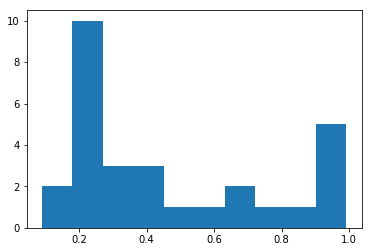

In [37]:
plt.hist((cg<hthresh).mean(axis=0))
good_celltypes = (cg<hthresh).mean(axis=0)<0.5 # Fewer than 20% bad enhancers (low coverage)
# print(np.sum(good_celltypes))
print('Keeping %d/%d cell types' % (np.sum(good_celltypes), len(good_celltypes)))

In [38]:
celltypes = df_mlevel.columns
celltypes = [re.sub("(Round2\.|_mCG)","",c) for c in celltypes]
df_mlevel.columns = celltypes

In [39]:
# Cell type names
df_cellnames = pd.read_csv('/cndd/Public_Datasets/CEMBA/BICCN_minibrain_data/data_freeze/supp_info/clusters_final/cluster_annotation_scf_round2.tsv',
                       sep='\t', index_col='cluster')

# Load ATAC data

In [40]:
atac = pd.read_csv(datadir+'enhancers_reptile_atac_norm.tsv',sep='\t') # Log10(CPM+1)
atac=atac.set_index('enhancer_idx',drop=False)
atac_enh_list = pd.read_csv(datadir+'enhancers_reptile.bed',sep='\t',header=None,names=['chr','start','end'])
atac = atac.join(atac_enh_list)
atac['enh_pos'] = atac['chr'].astype(str)+'_'+atac['start'].astype(str)+'_'+atac['end'].astype(str)
atac = atac.loc[~(atac['chr']=="chrY")]
df_atac = atac.set_index('enh_pos',drop=False)

In [41]:
# Make sure the ATAC and mCG data are both in the same column order
df_atac = df_atac[celltypes]
df_mlevel = df_mlevel[celltypes]

In [42]:
celltypes = df_mlevel.columns
celltypes = [re.sub("(Round2\.|_mCG)","",c) for c in celltypes]

In [115]:
# plt.boxplot(df_atac.T);
# plt.plot(df_atac.iloc[:100,0]);
(np.exp(df_atac)/np.exp(10)-1).sum(axis=0)

3-3    -298536.523987
8-2    -300205.199814
2-1    -298050.293083
6-1    -298846.165121
4-2    -298033.252759
1-1    -297946.898366
10-1         0.000000
3-2    -297820.906215
7-2    -298687.325229
5-1    -297958.087171
8-3    -301608.859633
6-6    -301760.586365
9-1    -298120.566125
3-1    -297935.024697
1-2    -297943.857988
5-2    -298356.758681
7-1    -299207.051743
5-4    -300770.991965
2-3    -298289.754795
9-2    -301098.623766
6-5    -298928.926926
6-3    -299338.747506
5-3    -298204.668718
8-1    -300053.598028
5-5    -301400.576998
2-2    -298080.824728
6-4    -298348.737563
4-1    -297909.929849
6-2    -298478.626618
dtype: float64

# Kmers

In [48]:
kdict=np.load(datadir+'kmers_6mers/kmer_dict.npy', allow_pickle=True)

In [49]:
# Load the kmer data per enhancer
kmer_counts=np.load(datadir+'kmers_6mers/count.npy')

In [50]:
kmer_enh = pd.read_csv(datadir+'enhancers_reptile.bed', sep='\t', 
                       header=None, names=['chr','start','end'])
kmer_enh['enh_pos'] = ['_'.join([str(i) for i in row]) for ind,row in kmer_enh.iterrows()]

In [51]:
kmer_enh['enh_num'] = np.arange(kmer_enh.shape[0])

In [52]:
kmer_enh = kmer_enh.set_index('enh_pos', drop=False)
kmer_counts.shape

(302106, 2080)

# Prepare the data and save

In [60]:
rna.shape, df_mlevel.shape, df_atac.shape

((6143, 29), (302096, 29), (302094, 29))

In [61]:
# enh_posu
genes2enhu = genes2enh.loc[rna.index]  # Note that this is larger than df_mlevelu
enh_posu = genes2enhu['enh_pos'].unique()
enh_posu = np.intersect1d(df_mlevel.index, enh_posu)
enh_posu = np.intersect1d(df_atac.index, enh_posu)

In [62]:
# Make sure all data frames have the cell types in the same order
genes2enhu = genes2enh.loc[rna.index]  # Note that this is larger than df_mlevelu
df_mlevelu = df_mlevel.loc[enh_posu]
df_atacu = df_atac.loc[enh_posu]
kmer_enhu = kmer_enh.loc[enh_posu]
df_mlevelu.shape, df_atacu.shape, kmer_enhu.shape

((159542, 29), (159542, 29), (159542, 5))

In [63]:
genes2enhu = genes2enhu.set_index('enh_pos',drop=False)
genes2enhu = genes2enhu.loc[enh_posu]
genes2enhu = genes2enhu.set_index('ensid',drop=False)

In [64]:
ensidu = np.intersect1d(rna.index, genes2enhu.index)
ensidu.shape
rna = rna.loc[ensidu]

In [65]:
# Determine the enhancer number for each gene-enhancer pair
genes2enhu = genes2enhu.loc[rna.index]  # Note that this is larger than df_mlevelu
genes2enhu['enh_num'] = kmer_enhu.loc[genes2enhu['enh_pos'],'enh_num'].values

In [66]:
kmer_countsu = kmer_counts[genes2enhu['enh_num'],:]

In [67]:
# Drop the bad cell types
bad_celltypes = cg.columns[((cg<hthresh).mean(axis=0)>0.5)]
bad_celltypes = [i.replace('Round2.','').replace('_mCG','') for i in bad_celltypes]
rnau = rna.drop(bad_celltypes,axis=1)
df_mlevelu = df_mlevelu.loc[:,rnau.columns]
df_atacu = df_atacu.loc[:,rnau.columns]
assert( (rnau.columns==df_mlevelu.columns).all() )
assert( (rnau.columns==df_atacu.columns).all() )
df_mlevelu.shape, df_atacu.shape, rnau.shape

((159542, 19), (159542, 19), (6143, 19))

In [68]:
# Save the data needed for training
fn_save_prefix = 'RegressData/Regress_data_%dgenes_%dcells_' % (rnau.shape[0], rnau.shape[1])
save_vars = ['genes2enhu', 'rnau', 'df_mlevelu', 'df_atacu','genes']
for var in save_vars:
    fn_save = fn_save_prefix+var+'.pkl'
    eval(var).to_pickle(fn_save)
    print(fn_save)
np.savez_compressed('RegressData/Regress_Feb16_data_kmer_countsu.npz', kmer_countsu=kmer_countsu)
print(fn_save_prefix +'kmer_countsu.pkl')

RegressData/Regress_data_6143genes_19cells_genes2enhu.pkl
RegressData/Regress_data_6143genes_19cells_rnau.pkl
RegressData/Regress_data_6143genes_19cells_df_mlevelu.pkl
RegressData/Regress_data_6143genes_19cells_df_atacu.pkl
RegressData/Regress_data_6143genes_19cells_genes.pkl
RegressData/Regress_data_6143genes_19cells_kmer_countsu.pkl


In [77]:
df_mlevelu.shape
df_mlevelu_mean = df_mlevelu.mean(axis=1)
df_mlevelu_mean_mean = df_mlevelu_mean.mean()
df_mlevelu_mean.fillna(df_mlevelu_mean_mean, inplace=True)
df_mlevelu_mean
df_mlevelu_mean.isna().sum()
df_mlevelu.isna().sum()

1-1    45651
1-2    35857
2-1    32509
2-2    36869
2-3    40409
3-1    32885
3-2    43763
4-1    46745
4-2    30263
5-1    16633
5-2    30688
5-3    23374
6-1    55360
6-2    41902
6-3    61600
6-4    67223
6-5    74498
7-1    34645
7-2    66919
dtype: int64

In [84]:
df_mlevelu2 = df_mlevelu.T.fillna(df_mlevelu_mean, axis=0).T

In [88]:
df_mlevelu = df_mlevelu2
df_mlevelu.shape

(159542, 19)

In [ ]:
# Impute the NaN values in mlevel
# df_mlevelu_mean = np.outer(df_mlevelu.median(axis=1).values, df_mlevelu.median(axis=0).values)
df_mlevelu_mean = df_mlevelu.mean(axis=1)
df_mlevelu_mean_mean = df_mlevelu_mean.mean()
df_mlevelu_mean.fillna(df_mlevelu_mean_mean, inplace=True)
# df_mlevelu_mean = pd.DataFrame(df_mlevelu_mean, index=df_mlevelu.index, columns=df_mlevelu.columns)
# df_mlevelu_mean = df_mlevelu_mean.fillna(df_mlevelu.median())
df_mlevelu = df_mlevelu.T.fillna(df_mlevelu_mean, axis=0).T

In [89]:
assert(not df_mlevelu.isna().any(axis=None))
assert(not df_atacu.isna().any(axis=None))
ensids = rnau.index.values

In [90]:
# Filter out bad enhancers
bad_enh = df_mlevelu.loc[genes2enhu.loc[:,'enh_pos']].isna().any(axis=1)
bad_enh = bad_enh | df_atacu.loc[genes2enhu.loc[:,'enh_pos']].isna().any(axis=1)
good_enh = [not i for i in bad_enh]
genes2enhu = genes2enhu[good_enh]
genes2enhu['enh_num2'] = np.arange(genes2enhu.shape[0])
kmer_countsu = kmer_countsu[good_enh]
K = kmer_countsu.shape[1] # Number of K-mers

In [91]:
genes2enhu

,gene_chr,gene_start,gene_end,gene_strand,ensid,gene_name,enh_chr,enh_start,enh_end,tss,enh_ctr,dtss,enh_pos,enh_num,enh_num2
ensid,,,,,,,,,,,,,,,
ENSMUSG00000000056,chr11,121237253,121255856,+,ENSMUSG00000000056,Narf,chr11,121222014,121222102,121237253,121222058.0,-15195.0,chr11_121222014_121222102,56804,0
ENSMUSG00000000056,chr11,121237253,121255856,+,ENSMUSG00000000056,Narf,chr11,121224639,121224765,121237253,121224702.0,-12551.0,chr11_121224639_121224765,56805,1
ENSMUSG00000000056,chr11,121237253,121255856,+,ENSMUSG00000000056,Narf,chr11,121224807,121224867,121237253,121224837.0,-12416.0,chr11_121224807_121224867,56806,2
ENSMUSG00000000056,chr11,121237253,121255856,+,ENSMUSG00000000056,Narf,chr11,121230688,121231382,121237253,121231035.0,-6218.0,chr11_121230688_121231382,56807,3
ENSMUSG00000000056,chr11,121237253,121255856,+,ENSMUSG00000000056,Narf,chr11,121232857,121233243,121237253,121233050.0,-4203.0,chr11_121232857_121233243,56808,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSMUSG00000115337,chr15,30597094,30626621,-,ENSMUSG00000115337,AC134414.1,chr15,30633898,30634432,30626621,30634165.0,-7544.0,chr15_30633898_30634432,101834,173671
ENSMUSG00000115337,chr15,30597094,30626621,-,ENSMUSG00000115337,AC134414.1,chr15,30642081,30642231,30626621,30642156.0,-15535.0,chr15_30642081_30642231,101835,173672
ENSMUSG00000115337,chr15,30597094,30626621,-,ENSMUSG00000115337,AC134414.1,chr15,30644837,30645261,30626621,30645049.0,-18428.0,chr15_30644837_30645261,101836,173673


In [93]:
# Gather all the mC and ATAC data into a numpy array for quick indexing
# %%timeit
ensids = rnau.index.values
max_nenh = genes2enhu.loc[:,'gene_chr'].groupby('ensid').count().max()
Ne = ensids.shape[0]
Nc = df_mlevelu.shape[1]
rna_lookup = rnau.loc[ensids].to_numpy()
ml_lookup = np.zeros((Ne,max_nenh,Nc))
atac_lookup = np.zeros((Ne,max_nenh,Nc))
kmeri_lookup = [];
for i,ens in enumerate(ensids):
    curr_enh = genes2enhu.loc[ens,['enh_pos','enh_num2']]
    mlu = df_mlevelu.loc[curr_enh['enh_pos']].to_numpy()
    atacu = df_atacu.loc[curr_enh['enh_pos']]
    ml_lookup[i,:mlu.shape[0],:] = mlu
    atac_lookup[i,:atacu.shape[0],:] = atacu
    kmeri_lookup.append(curr_enh['enh_num2'])

In [94]:
np.savez_compressed(fn_save_prefix+'AllLookups.npz',
                   ml_lookup=ml_lookup,
                   atac_lookup=atac_lookup,
                   rna_lookup=rna_lookup,
                   kmeri_lookup=kmeri_lookup)

In [96]:
ml_lookup.shape, atac_lookup.shape

((6143, 1030, 19), (6143, 1030, 19))

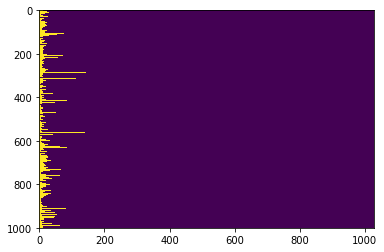

In [100]:
plt.imshow(ml_lookup[:1000,:,0]>0,aspect='auto')